# Advanced Quadrature Implementations

In [1]:
import math
from importlib import reload

import matplotlib.pyplot as plt
import pickle
import numpy as np

from tqdm.notebook import tqdm

from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time.environments import cartpole2
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

from pprint import pprint

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
cartpole2 = reload(cartpole2)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CartPole-OURS-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


## Prepare some data to test on

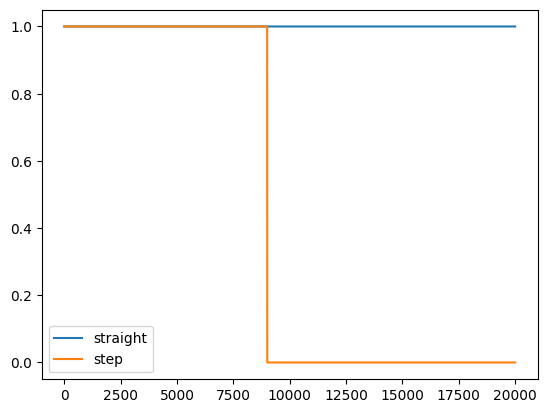

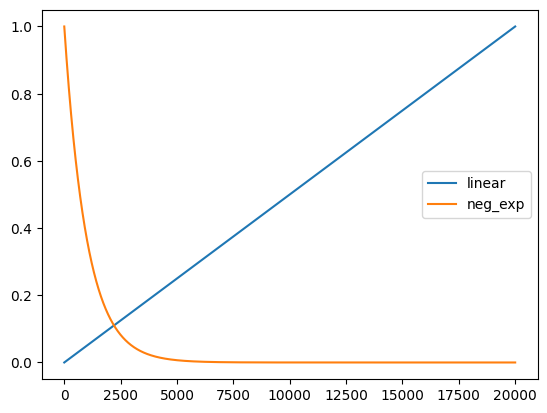

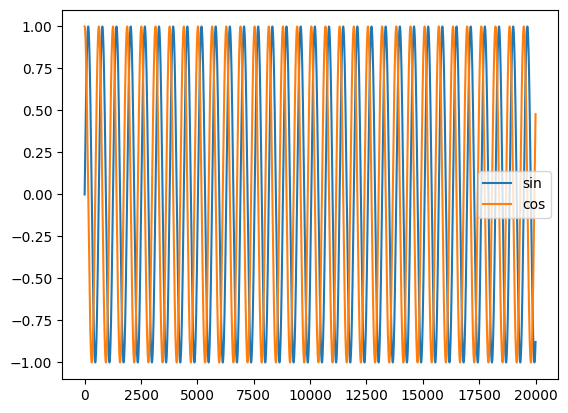

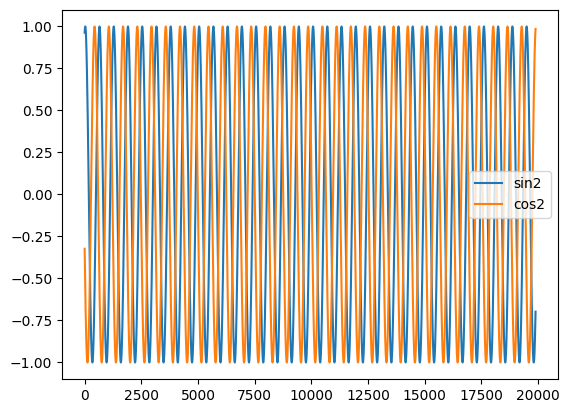

In [14]:
seed = 42

value_est.reset_randomness(seed, env=None)

data = {
    "straight": np.array([1] * 20_000),
    "step": np.array([1] * 9_000 + [0] * 11_000),
    "linear": np.arange(0, 20_000, 1) * 0.0001 / 2,
    "neg_exp": np.exp(-np.arange(0, 20, 0.001)),
    "sin": np.sin(np.arange(0, 200, 0.01)),
    "cos": np.cos(np.arange(0, 200, 0.01)),
    "sin2": np.sin(np.arange(1.3, 200.3, 0.01)),
    "cos2": np.cos(np.arange(1.9, 200.9, 0.01)),
}

for idx, (k, v) in enumerate(data.items()):
    if idx % 2 == 0:
        plt.figure()
    plt.plot(v, label=k)
    plt.legend()

In [16]:
true_integrals = {k: np.sum(v) for k, v in data.items()}
pprint(true_integrals)

{'cos': -87.07259580994176,
 'cos2': -111.40649854276533,
 'linear': 9999.5,
 'neg_exp': 1000.5000812711476,
 'sin': 51.717453803589905,
 'sin2': -44.77331462678737,
 'step': 9000,
 'straight': 20000}


In [17]:
unif_sampler_params = np.power(2, np.arange(0, 11, 2))
quad_sampler_params = np.concatenate(
    (np.array([0]), np.power(2, np.arange(-3.0, 12, 2))), axis=0
)

print('unif_sampler_params:', unif_sampler_params)
print('quad_sampler_params:', quad_sampler_params)

samplers_tried = {
    f'q{p}': approx_integrators.AdaptiveQuadratureIntegrator(tolerance=p)
    for p in quad_sampler_params
}
samplers_tried.update({
    f'u{p}': approx_integrators.UniformlySpacedIntegrator(p)
    for p in unif_sampler_params
})


unif_sampler_params: [   1    4   16   64  256 1024]
quad_sampler_params: [0.000e+00 1.250e-01 5.000e-01 2.000e+00 8.000e+00 3.200e+01 1.280e+02
 5.120e+02 2.048e+03]


In [44]:
approx_integrals = {}
num_pivots = {}

for label, value_seq in tqdm(data.items()):
    print("data:", label)
    approx_integrals[label] = {}
    num_pivots[label] = {}
    for sampler_name, sampler in samplers_tried.items():
        integral, all_pivots = sampler.integrate(value_seq)
        approx_integrals[label][sampler_name] = integral
        num_pivots[label][sampler_name] = len(all_pivots)
    # approx_integrals[sampler_name] = np.array(approx_integrals[sampler_name])
    # num_pivots[sampler_name] = np.array(num_pivots[sampler_name])


  0%|          | 0/8 [00:00<?, ?it/s]

data: straight
data: step
data: linear
data: neg_exp
data: sin
data: cos
data: sin2
data: cos2


In [45]:

pprint(num_pivots)


{'cos': {'q0.0': 20000,
         'q0.125': 19446,
         'q0.5': 17901,
         'q128.0': 9,
         'q2.0': 11609,
         'q2048.0': 3,
         'q32.0': 199,
         'q512.0': 5,
         'q8.0': 405,
         'u1': 20000,
         'u1024': 21,
         'u16': 1251,
         'u256': 80,
         'u4': 5001,
         'u64': 314},
 'cos2': {'q0.0': 19900,
          'q0.125': 19399,
          'q0.5': 15645,
          'q128.0': 13,
          'q2.0': 10095,
          'q2048.0': 5,
          'q32.0': 217,
          'q512.0': 7,
          'q8.0': 2975,
          'u1': 19900,
          'u1024': 21,
          'u16': 1245,
          'u256': 79,
          'u4': 4976,
          'u64': 312},
 'linear': {'q0.0': 3,
            'q0.125': 3,
            'q0.5': 3,
            'q128.0': 3,
            'q2.0': 3,
            'q2048.0': 3,
            'q32.0': 3,
            'q512.0': 3,
            'q8.0': 3,
            'u1': 20000,
            'u1024': 21,
            'u16': 1251,
           

In [46]:
pprint(approx_integrals)


{'cos': {'q0.0': -87.07259580994217,
         'q0.125': -87.07182118011067,
         'q0.5': -87.07222735458296,
         'q128.0': 16412.46016840599,
         'q2.0': -87.0700288897697,
         'q2048.0': 16015.410005455395,
         'q32.0': 15793.856874650714,
         'q512.0': 16328.905131894973,
         'q8.0': 15798.000535565456,
         'u1': -87.07259580994237,
         'u1024': 443.6383906327438,
         'u16': -86.88432065571209,
         'u256': -26.561721163685707,
         'u4': -87.06153751981124,
         'u64': -83.78107276496462},
 'cos2': {'q0.0': -111.40649854276539,
          'q0.125': -111.40649844775974,
          'q0.5': 1015.8348625881273,
          'q128.0': 10630.796661619039,
          'q2.0': 1015.8397175082837,
          'q2048.0': 10446.367505212113,
          'q32.0': 10486.939061078834,
          'q512.0': 10591.415536463217,
          'q8.0': 2627.7380453196865,
          'u1': -111.4064985427643,
          'u1024': 183.62375534182635,
          'u

### Plot the approximation qualities


/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_92313/4188527242.py:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


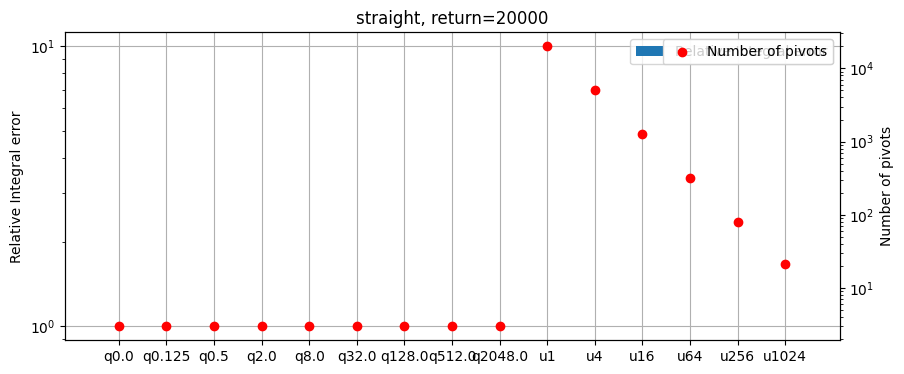

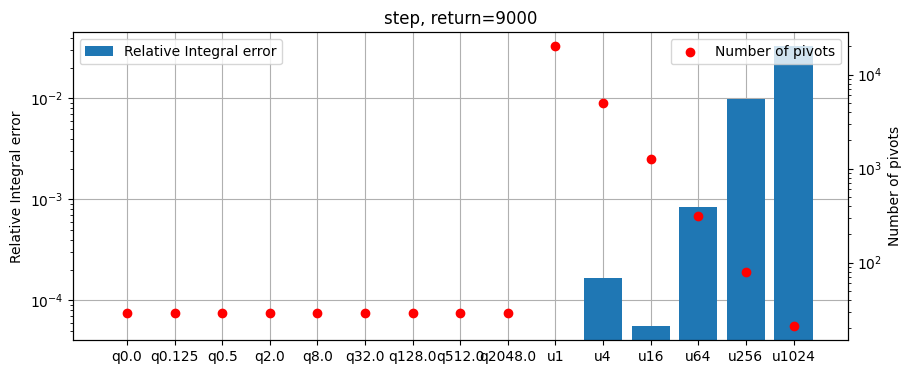

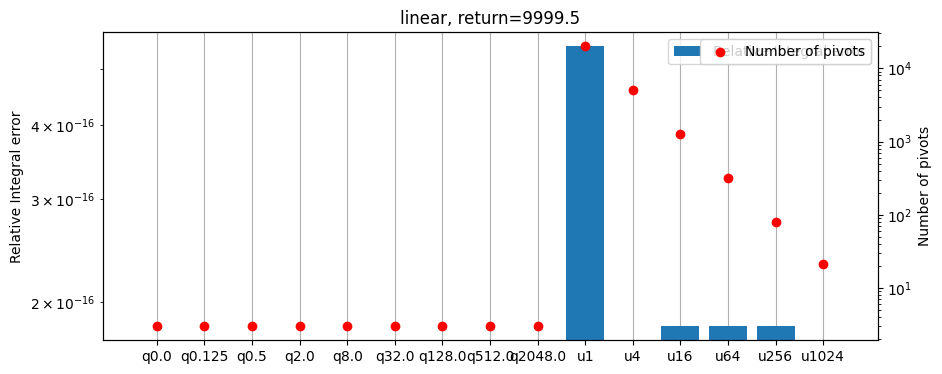

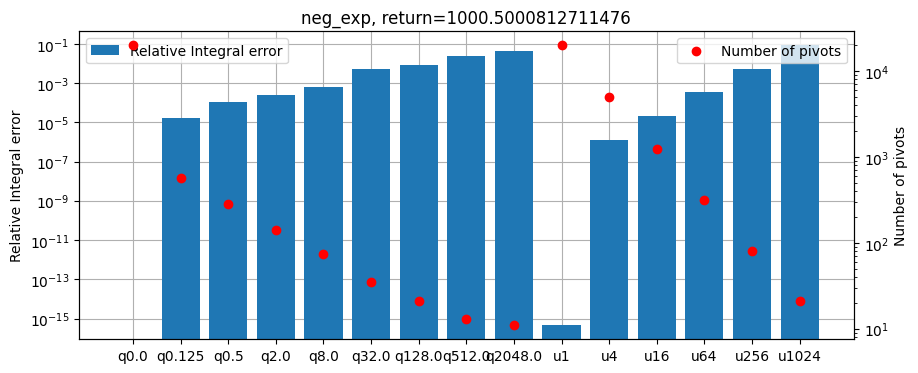

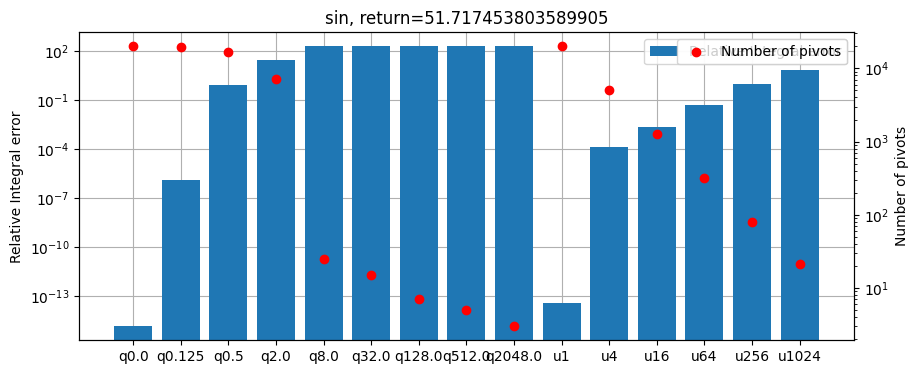

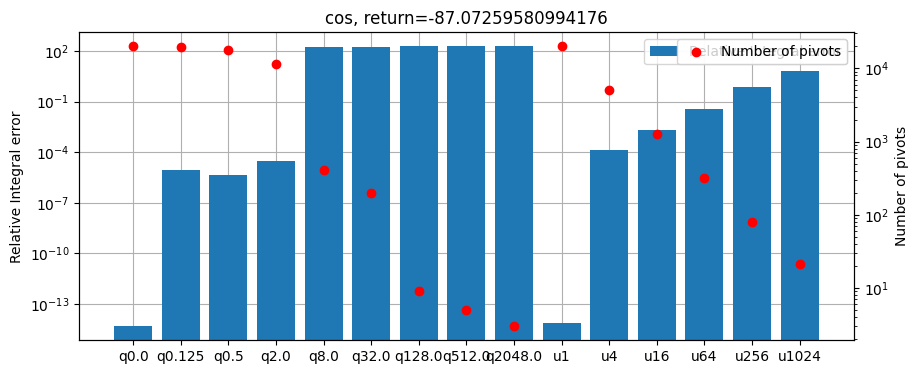

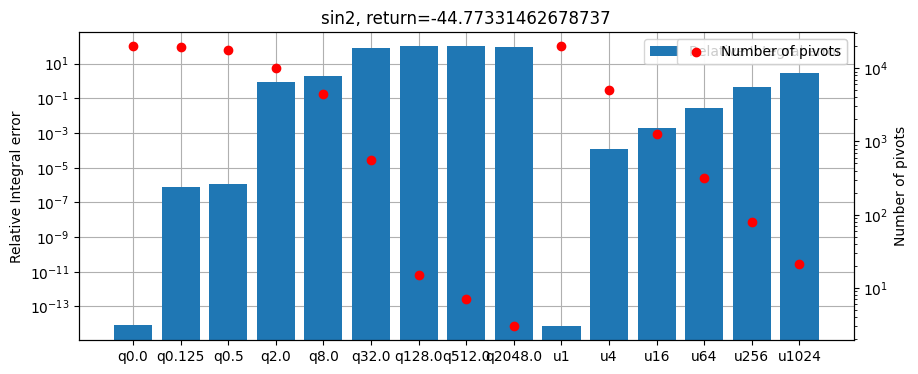

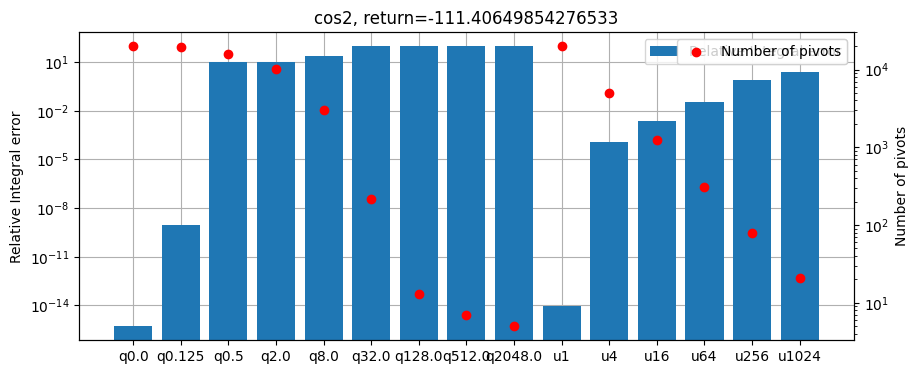

In [57]:
# Each data gets a different plot.
# -- on each plot, samplers go on the x-axes
# -- y-axes is the integral value error AND the number of pivots

all_abs_errs = {}
all_rel_errs = {}

for data_name in data.keys():
    plt.figure(figsize=(10, 4))
    plt.title(f"{data_name}, return={true_integrals[data_name]}")
    ax = plt.gca()
    ax.grid()
    ax.set_axisbelow(True)
    ax2 = ax.twinx()

    method_names = []
    errs = []
    num_pivots_ = []
    all_abs_errs[data_name] = {}
    all_rel_errs[data_name] = {}

    for sampler_name, sampler in samplers_tried.items():
        method_names.append(sampler_name)
        abs_err = abs(true_integrals[data_name] - approx_integrals[data_name][sampler_name])
        rel_err = abs_err / abs(true_integrals[data_name])
        all_rel_errs[data_name][sampler_name] = rel_err
        all_abs_errs[data_name][sampler_name] = abs_err
        errs.append(rel_err)
        num_pivots_.append(num_pivots[data_name][sampler_name])
    ax.bar(method_names, errs, label="Relative Integral error")
    ax2.scatter(method_names, num_pivots_, label="Number of pivots", color="red")
    # ax2.hlines(5, -1, len(method_names), color="gray", linestyle="--")
    ax.set_yscale("log")
    # ax.set_yticks([20, 200, 500])
    # ax.set_ylim(0, 200_000)
    ax2.set_yscale("log")
    ax.set_ylabel("Relative Integral error")
    ax2.set_ylabel("Number of pivots")
    # plt.yscale("log")
    # plt.legend()
    ax.legend(loc=0)
    ax2.legend()

## In-depth explore

In [56]:
# all_abs_errs
# all_rel_errs

pprint(all_abs_errs["cos2"])
pprint(all_rel_errs["cos2"])


{'q0.0': 5.684341886080802e-14,
 'q0.125': 9.500558917352464e-08,
 'q0.5': 1127.2413611308925,
 'q128.0': 10742.203160161804,
 'q2.0': 1127.246216051049,
 'q2048.0': 10557.774003754877,
 'q32.0': 10598.345559621599,
 'q512.0': 10702.822035005982,
 'q8.0': 2739.144543862452,
 'u1': 1.0373923942097463e-12,
 'u1024': 295.0302538845917,
 'u16': 0.24960512123195144,
 'u256': 91.03449264666837,
 'u4': 0.01413964951457558,
 'u64': 4.1088813869090615}
{'q0.0': 5.102343185033113e-16,
 'q0.125': 8.527831896364204e-10,
 'q0.5': 10.118272954231491,
 'q128.0': 96.42348786357576,
 'q2.0': 10.118316532660218,
 'q2048.0': 94.76802647829463,
 'q32.0': 95.13220232438451,
 'q512.0': 96.06999748670421,
 'q8.0': 24.58693684561842,
 'u1': 9.311776312685432e-15,
 'u1024': 2.6482319949346507,
 'u16': 0.002240489778395972,
 'u256': 0.8171380829433679,
 'u4': 0.00012691943198580853,
 'u64': 0.036881882481315}
